In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nruns=1
run='ntest_mean'
extra=True
spsp = []
selected_spsp = []
photometry = []
nzs = []
sparams = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    photometry.append(np.load("photo_samples/photo_"+run+"_"+str(i)+".npy"))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))
    sparams.append(np.load("sps_parameter_samples/sparams_"+run+"_"+str(i)+".npy"))

spsp = np.vstack(spsp)
selected_spsp = np.vstack(selected_spsp)
photometry = np.vstack(photometry)
nzs = np.vstack(nzs)
sparams = np.vstack(sparams)
print(spsp.shape, selected_spsp.shape, photometry.shape, nzs.shape, sparams.shape)

(2, 500000, 17) (2, 3) (2, 500000, 5) (2, 3) (2, 3, 100)


In [12]:
import lbg_forecast.priors_gp_massfunc as gpmf 
import lbg_forecast.utils as utils

real = 0
tot_m = np.log10(spsp[real, :, -1])
tot_z = spsp[real, :][:, 0]
sparams_real = sparams[real, :, :]

print(tot_m.shape, tot_z.shape)

mass_function_prior = gpmf.MassFunctionPrior('.', mean=False)

dz=0.05
dlogm=0.05

start_z = 0
end_z = 7
z_bin = np.linspace(start_z, end_z, int((end_z-start_z)/dz))
z_midpoint = (z_bin[1:]+z_bin[:-1])/2

start_logm = 7
end_logm = 13
m_bin = np.linspace(start_logm, end_logm, int((end_logm-start_logm)/dlogm))
m_midpoint = (m_bin[1:]+m_bin[:-1])/2

u_sel = np.squeeze(selected_spsp[real, :][0])
u_sel_m = np.log10(u_sel[:, -1])
u_sel_z = u_sel[:, 0]

g_sel = np.squeeze(selected_spsp[real, :][1])
g_sel_m = np.log10(g_sel[:, -1])
g_sel_z = g_sel[:, 0]

r_sel = np.squeeze(selected_spsp[real, :][2])
r_sel_m = np.log10(r_sel[:, -1])
r_sel_z = r_sel[:, 0]

u_counts_2d = np.histogram2d(u_sel_z, u_sel_m, bins=(z_bin, m_bin), density=False)[0]
g_counts_2d = np.histogram2d(g_sel_z, g_sel_m, bins=(z_bin, m_bin), density=False)[0]
r_counts_2d = np.histogram2d(r_sel_z, r_sel_m, bins=(z_bin, m_bin), density=False)[0]
tot_counts_2d = np.histogram2d(tot_z, tot_m, bins=(z_bin, m_bin), density=False)[0]

phi_z_m_2d = np.zeros_like(u_counts_2d)
da_2d = np.zeros_like(phi_z_m_2d)

i = 0
for z in z_midpoint:
    da = dlogm*mass_function_prior.volume_element(z, dz)
    phi_z_m = mass_function_prior.mass_function(z, m_midpoint, sparams_real)
    da_2d[i, :] = da
    phi_z_m_2d[i, :] = phi_z_m
    i+=1

p_detection_2d_u = np.divide(u_counts_2d, tot_counts_2d, out=np.zeros_like(u_counts_2d), where=(tot_counts_2d!=0))
n_gal_u = np.sum(p_detection_2d_u*phi_z_m_2d*da_2d)
n_den_u = n_gal_u/utils.FULL_SKY_DEG2

p_detection_2d_g = np.divide(g_counts_2d, tot_counts_2d, out=np.zeros_like(g_counts_2d), where=(tot_counts_2d!=0))
n_gal_g = np.sum(p_detection_2d_g*phi_z_m_2d*da_2d)
n_den_g = n_gal_g/utils.FULL_SKY_DEG2

p_detection_2d_r = np.divide(r_counts_2d, tot_counts_2d, out=np.zeros_like(r_counts_2d), where=(tot_counts_2d!=0))
n_gal_r = np.sum(p_detection_2d_r*phi_z_m_2d*da_2d)
n_den_r = n_gal_r/utils.FULL_SKY_DEG2

print(n_den_u, n_den_g, n_den_r)

print(np.sum(phi_z_m_2d*da_2d))


(500000,) (500000,)
8342.326032410181 14065.82257671851 1168.9128174192722
131559272401.39745


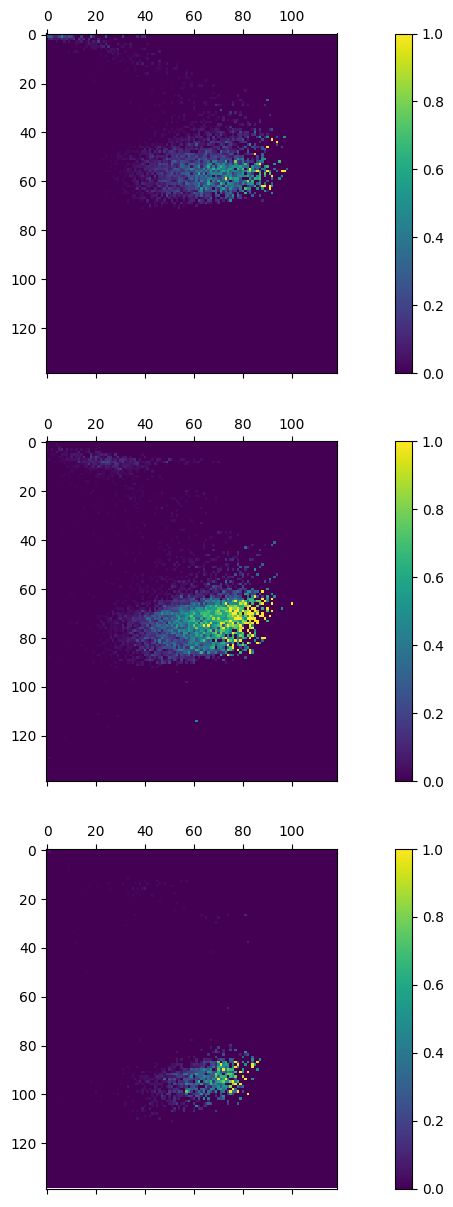

In [33]:
f, ax = plt.subplots(3, 1, figsize = (15, 15))
uplot = ax[0].matshow(p_detection_2d_u)
f.colorbar(uplot)
gplot = ax[1].matshow(p_detection_2d_g)
f.colorbar(gplot)
rplot = ax[2].matshow(p_detection_2d_r)
f.colorbar(rplot)

7.378151260504202
7.4789915966386555
8.084033613445378


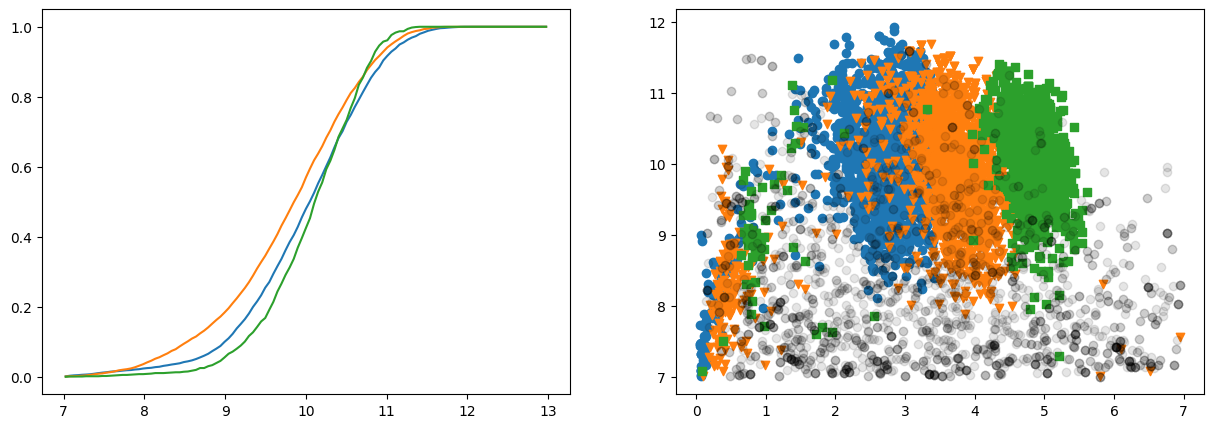

In [14]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

counts_u, _ = np.histogram(u_sel_m, bins=m_bin, density=False)
total_counts_u = u_sel.shape[0]
cumulative_sum_u = np.cumsum(counts_u)/total_counts_u

counts_g, _ = np.histogram(g_sel_m, bins=m_bin, density=False)
total_counts_g = g_sel.shape[0]
cumulative_sum_g = np.cumsum(counts_g)/total_counts_g

counts_r, _ = np.histogram(r_sel_m, bins=m_bin, density=False)
total_counts_r = r_sel.shape[0]
cumulative_sum_r = np.cumsum(counts_r)/total_counts_r

#mlim = 8.0

ax[0].plot(m_midpoint, cumulative_sum_u)
#ax[0].vlines(mlim, 0, 1, colors='k', ls='--')

ax[0].plot(m_midpoint, cumulative_sum_g)
#ax[0].vlines(mlim, 0, 1, colors='k', ls='--')

ax[0].plot(m_midpoint, cumulative_sum_r)
#ax[0].vlines(mlim, 0, 1, colors='k', ls='--')

print(m_midpoint[np.where(cumulative_sum_u < 0.01)[0][-1]])
print(m_midpoint[np.where(cumulative_sum_g < 0.01)[0][-1]])
print(m_midpoint[np.where(cumulative_sum_r < 0.01)[0][-1]])

plot_samples = 2000
ax[1].scatter(u_sel_z[:plot_samples], u_sel_m[:plot_samples], alpha=1.0)
ax[1].scatter(g_sel_z[:plot_samples], g_sel_m[:plot_samples], alpha=1.0, marker='v')
ax[1].scatter(r_sel_z[:plot_samples], r_sel_m[:plot_samples], alpha=1.0, marker='s')
ax[1].scatter(tot_z[:plot_samples], tot_m[:plot_samples], color='k', alpha=0.1)
